In [26]:
"""Housing.ipynb

    Predicting Housing Prices based on 79 features that describe almost every aspect of a residential home. More information about the data can be found at: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Base Imports
"""

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import sys 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
"""Load in data and create a combined table for easy data clean up.  Will apply same mappings to each DF independently of combined; using combined to see any correlation on various stats tests."""

train_df = pd.read_csv(r"C:\Users\chho8001\Desktop\Data Science\Housing-Prices--master\train.csv")
test_df = pd.read_csv(r"C:\Users\chho8001\Desktop\Data Science\Housing-Prices--master\test.csv")
combine = pd.concat([train_df, test_df])

In [28]:
combine_null = combine[combine['SalePrice'].isnull()]
combine_null['SalePrice']
train_df['SalePrice'].isna().any()

False

In [ ]:
"""check for null values"""

combine.columns[combine.isna().any()].tolist()

In [30]:
def plot_missing(df, showplot = True):
    
    # Get dataframe with percentage of missing values
    missing = pd.DataFrame(df.isnull().sum(), columns = ['perc_missing'])
    missing = missing.loc[missing['perc_missing'] > 0]
    missing = (missing/len(df))*100
    
    # Plot resulting dataframe
    missing = missing.sort_values('perc_missing')
    if(showplot):
        ax = missing.plot(
            kind = 'barh',
            figsize=(10,8),
            title = 'Percentage of Missing Values in Dataset by Feature',
            legend = None,
            color = 'coral'
        )

        for i in ax.patches:
            ax.text(
                i.get_width()+.3, i.get_y(),
                str(round(i.get_width(), 2)), 
                fontsize=12,
                color='blue'
            )

        plt.style.use('ggplot')
        plt.show()
    
    return missing


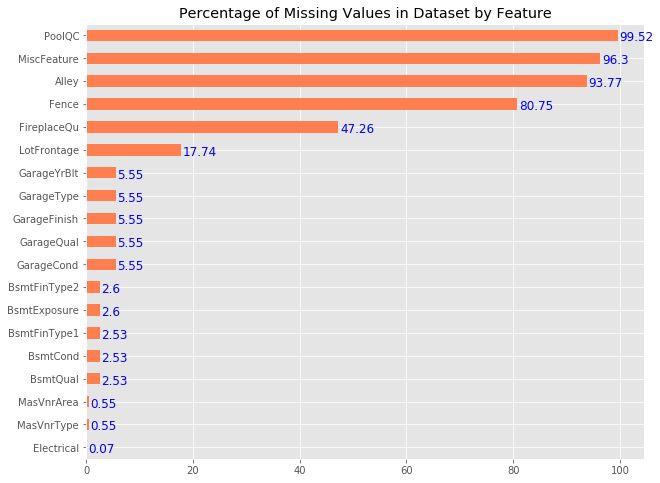

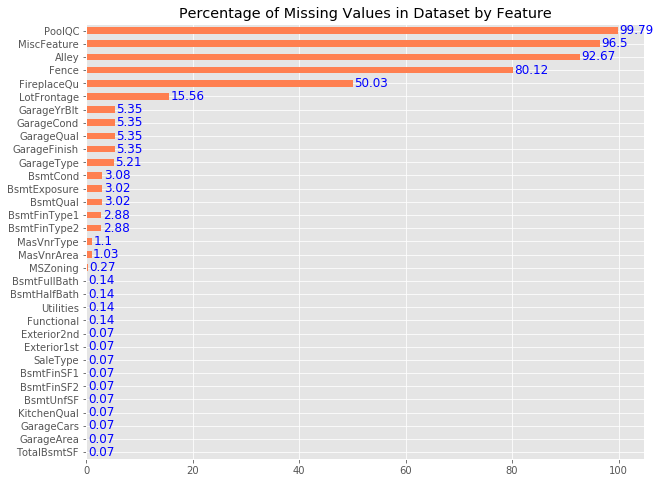

,perc_missing
TotalBsmtSF,0.068540
GarageArea,0.068540
GarageCars,0.068540
KitchenQual,0.068540
BsmtUnfSF,0.068540
BsmtFinSF2,0.068540
BsmtFinSF1,0.068540
SaleType,0.068540
Exterior1st,0.068540
Exterior2nd,0.068540


In [31]:
plot_missing(train_df)
plot_missing(test_df)

We notice that five of the variables have a very high number of missing values and we want to handle these early on so they don't disrupt our modeling process 
We'll write a function that so we can either drop or replace them with appropriate values depending on their data type (numeric, character, etc.) 

In [32]:
#Writing a function to handle NA values
def handle_na(train, test, cols_to_clean, cols_to_drop):
    if(cols_to_drop):
        train.drop(cols_to_drop, axis = 1, inplace = True)
        test.drop(cols_to_drop, axis = 1, inplace = True)
    
    if(cols_to_clean):
        for col in cols_to_clean:
            train[col+'_is_na'] = train[col].isnull()
            test[col+'_is_na'] = test[col].isnull()
        
    for col in test.columns:
        # If numeric, fill with median
        if np.issubdtype(train[col].dtype, np.number):
            train.loc[train[col].isnull() == True, col] = train[col].median()
            test.loc[test[col].isnull() == True, col] = train[col].median()

        # If object, fill with mode
        if (train[col].dtype == 'O'): 
            train.loc[train[col].isnull() == True, col] = train[col].mode().iloc[0]
            test.loc[test[col].isnull() == True, col] = train[col].mode().iloc[0]
            
    print(f'Shape of Train Set: {train.shape}')
    print(f'Shape of Test Set : {test.shape}')

    return train, test

We find a way to bypass the NA values and develop a correlation matrix for variables without missing values.
This will give us insight into which variables are most conducive to modeling 

In [33]:
cols_to_drop = []
cols_to_clean = []
new_train = train_df.copy()
new_test = test_df.copy()

new_train, new_test = handle_na(new_train, new_test, cols_to_clean, cols_to_drop)

new_combine = pd.concat([new_train, new_test])
new_combine.head(10)
corr = combine.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Shape of Train Set: (1460, 81)
Shape of Test Set : (1459, 80)


In [34]:
#turn correlations into absolute values for fair comparison 
new_corr = corr.abs()

#Calculating the correlation for each variable with the target variable 
corr_input = combine[combine.columns[1:]].corr()['SalePrice'][:].abs()
type(corr_input)
corr_input.sort_values(ascending=False)


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

In [37]:
#checking to make sure the dependent variable has no zeros 
new_combine[new_combine['SalePrice'] == 0].sum()
#Replacing all NA values in dependent variable with zeros
new_combine['SalePrice'].fillna(0, inplace=True)

In [47]:
new_combine["OverallQual"]

0       7.0
1       6.0
2       7.0
3       7.0
4       8.0
       ... 
1454    4.0
1455    4.0
1456    5.0
1457    5.0
1458    7.0
Name: OverallQual, Length: 2919, dtype: float64

In [ ]:
#removing outliers using z-scores 
from scipy import stats
#calculating z-score ONLY on numeric columns
num_cols = new_combine._get_numeric_data().columns 

z = np.abs(stats.zscore(new_combine[num_cols]))
print(z)
threshold = 3 #Setting the Z-score to 3 because the majority of values should be within 3 standard deviations of the mean
print(np.where(z>3)) #Hence, any Z-score greater than 3 (any value greater than 3 standard deviations of the mean) will be counted as an outlier
np.set_printoptions(threshold=sys.maxsize)
new_combine_1 = new_combine[(z < 3).all(axis=1)] #This ensures all columns satisfy the constraints and removes the outliers
new_combine_1.shape #Gets rid of 870 rows

In [ ]:
"""
Another way to remove outliers 
"""

#removing outliers using IQR
Q1 = new_combine.quantile(0.25)
Q3 = new_combine.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(new_combine < (Q1 - 1.5 * IQR)) |(new_combine > (Q3 + 1.5 * IQR))



In [76]:
#replacing all zero values of SalePrice with the MEAN house price 
new_combine_1['SalePrice'] = new_combine_1['SalePrice'].replace(0, new_combine_1['SalePrice'].mean())

In [80]:
#Chose top 10 highest correlated variable with Sale Price as the input features 
X = new_combine_1[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','FullBath','FullBath','TotRmsAbvGrd',
               'YearBuilt','YearRemodAdd']]
y = new_combine_1['SalePrice']

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [82]:
#creating and training the model
from sklearn.linear_model import LinearRegression 
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

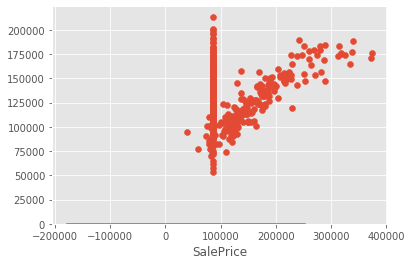

In [83]:
#predicting the model
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)
sns.distplot((y_test-predictions),bins=50);

In [ ]:
#evaluating Metrics
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
